In [44]:
import csv
import sys
import os
import pickle
import random
import numpy as np
import time
import operator

import matplotlib
import matplotlib.pyplot as plt

from collections import Counter

from scipy.stats import entropy
from scipy.stats import spearmanr
from scipy.stats import zscore
from sklearn.linear_model import LinearRegression
from sklearn.metrics.pairwise import cosine_similarity

In [45]:
sys.path.append('../python')
from permutation import permutation

In [46]:
vg_noun_data=pickle.load(open("../data/dumped_embeddings/vg_noun_concept_least20_swav_bert_20.pkl","rb"))
vg_verb_data=pickle.load(open("../data/dumped_embeddings/vg_verb_concept_least20_swav_bert_20.pkl","rb"))

In [47]:
# aggregate both visual embeddings and language embeddings
def aggregate_embeddings_visual_and_language(input_struct,n_sample_per_visual,n_sample_per_language):
	words=input_struct['words']
	embed_dict=dict()
	for word in words:
		visual_temp=np.mean(np.array(random.sample(input_struct['embeds'][word]['visual'],n_sample_per_visual)),axis=0)
		language_temp=np.mean(np.array(random.sample(input_struct['embeds'][word]['language'],n_sample_per_language)),axis=0)
		embed_dict[word]=dict(visual=visual_temp,language=language_temp)
	return dict(embeds=embed_dict,words=words)

In [48]:
aggregated_vg_noun_data=aggregate_embeddings_visual_and_language(vg_noun_data,20,20)
aggregated_vg_verb_data=aggregate_embeddings_visual_and_language(vg_verb_data,20,20)

In [49]:
# kuperman aoa
noun_aoa_dict=dict()
with open("../data/processed/AoA_Kuperman.csv","r") as f:
    next(f)
    for row in f:
        temp=row.replace('\n','').replace('\r','').split(",")
        if temp[0]:
            if temp[0] in vg_noun_data["words"]:
                noun_aoa_dict[temp[0]]=float(temp[4])
noun_aoa_sorted= sorted(noun_aoa_dict.items(), key=operator.itemgetter(1))

In [50]:
# kuperman aoa
verb_aoa_dict=dict()
with open("../data/processed/AoA_Kuperman.csv","r") as f:
    next(f)
    for row in f:
        temp=row.replace('\n','').replace('\r','').split(",")
        if temp[0]:
            if temp[0] in vg_verb_data["words"]:
                verb_aoa_dict[temp[0]]=float(temp[4])
verb_aoa_sorted= sorted(verb_aoa_dict.items(), key=operator.itemgetter(1))

In [51]:
noun_freq_dict=dict()
with open("../data/processed/childes_noun_freq.txt","r") as f:
    next(f)
    for row in f:
        temp=row.replace("\n","").split(" ")
        noun_freq_dict[temp[0]]=int(temp[1])

In [52]:
verb_freq_dict=dict()
with open("../data/processed/childes_verb_freq.txt","r") as f:
    next(f)
    for row in f:
        temp=row.replace("\n","").split(" ")
        verb_freq_dict[temp[0]]=int(temp[1])

In [53]:
def get_variance(struct):
    words=struct["words"]
    visual_variance=dict()
    language_variance=dict()
    for word in words:
        visual_embeddings=struct["embeds"][word]["visual"]
        visual_variance[word]=np.mean(np.linalg.norm(visual_embeddings-np.mean(visual_embeddings,axis=0),axis=1))
        language_embeddings=struct["embeds"][word]["language"]
        language_variance[word]=np.mean(np.linalg.norm(language_embeddings-np.mean(language_embeddings,axis=0),axis=1))
    return visual_variance,language_variance

In [54]:
noun_visual_variance,noun_language_variance=get_variance(vg_noun_data)
verb_visual_variance,verb_language_variance=get_variance(vg_verb_data)

In [55]:
def get_distinctness_from_nearest_5(struct):
    words=struct["words"]
    visual_centers=dict()
    language_centers=dict()
    for word in words:
        visual_embeddings=np.array(struct["embeds"][word]["visual"])
        visual_centers[word]=np.mean(visual_embeddings,axis=0)
        language_embeddings=np.array(struct["embeds"][word]["language"])
        language_centers[word]=np.mean(language_embeddings,axis=0)
    visual_distinctness=dict()
    language_distinctness=dict()
    for word in words:
        visual_distances=[np.linalg.norm(visual_centers[word]-visual_centers[temp]) for temp in words]
        visual_distinctness[word]=np.sum(sorted(visual_distances)[:6])/5
        language_distances=[np.linalg.norm(language_centers[word]-language_centers[temp]) for temp in words]
        language_distinctness[word]=np.sum(sorted(language_distances)[:6])/5
    return visual_distinctness,language_distinctness

In [56]:
noun_visual_distinctness,noun_language_distinctness=get_distinctness_from_nearest_5(vg_noun_data)
verb_visual_distinctness,verb_language_distinctness=get_distinctness_from_nearest_5(vg_verb_data)

In [57]:
def get_alignment_strength_of_true_mapping(struct,concept_list):
    visual_embeddings_list=list()
    langauge_embeddings_list=list()
    for concept in concept_list:
        embeddings=struct["embeds"][concept[0]]
        visual_embeddings_list.append(embeddings["visual"])
        langauge_embeddings_list.append(embeddings["language"])
    z_0=np.array(visual_embeddings_list)
    z_1=np.array(langauge_embeddings_list)
    sim_z_0=cosine_similarity(z_0)
    sim_z_1=cosine_similarity(z_1)
    return spearmanr(sim_z_0.flatten(),sim_z_1.flatten())[0]
    # print(spearmanr(sim_z_0.flatten(),sim_z_1.flatten())[0])
    # set_size, n_mismatch_array, rho_array = permutation(z_0,z_1,max_perm=1,n_perm_keep=1)
    # true_mapping_idx=np.where(n_mismatch_array==0)[0]
    # print(rho_array)
    # print(rho_array[true_mapping_idx])
    # sss
    # return rho_array[true_mapping_idx]
    

In [58]:
cooccurence_data=pickle.load(open("../data/processed/dumped/verb_cooccurence_visual.pkl","rb"))

In [59]:
co_table=cooccurence_data["table"]
co_nouns=cooccurence_data["nouns"]
co_verbs=cooccurence_data["verbs"]

In [60]:
co_bi_table=np.zeros(co_table.shape)
for i,row in enumerate(co_table):
    for j,cell in enumerate(row):
        if cell:
            co_bi_table[i][j]=1
        else:
            co_bi_table[i][j]=0

In [61]:
heaviness_list=np.sum(co_bi_table,axis=1)
heaviness=dict()
for i,verb in enumerate(co_verbs):
    concept=verb.split(".")[0]
    if concept in vg_verb_data["words"]:
        heaviness[concept]=heaviness_list[i]
heaviness_sorted= sorted(heaviness.items(), key=operator.itemgetter(1))

In [62]:
heaviness_sorted

[('guard', 1.0),
 ('reach', 1.0),
 ('wear', 1.0),
 ('give', 1.0),
 ('total', 2.0),
 ('juggle', 2.0),
 ('fly', 3.0),
 ('serve', 4.0),
 ('burn', 4.0),
 ('dock', 5.0),
 ('shoot', 5.0),
 ('inspect', 5.0),
 ('photograph', 6.0),
 ('gesticulate', 6.0),
 ('clasp', 7.0),
 ('film', 7.0),
 ('shop', 7.0),
 ('buy', 7.0),
 ('milk', 7.0),
 ('smoke', 8.0),
 ('drip', 8.0),
 ('bloom', 9.0),
 ('arrange', 9.0),
 ('dirty', 9.0),
 ('sport', 9.0),
 ('squat', 9.0),
 ('pick', 10.0),
 ('litter', 10.0),
 ('lock', 10.0),
 ('let', 11.0),
 ('advertise', 11.0),
 ('shield', 11.0),
 ('peer', 11.0),
 ('shake', 11.0),
 ('urge', 12.0),
 ('paddle', 12.0),
 ('dress', 12.0),
 ('etch', 12.0),
 ('crash', 12.0),
 ('add', 13.0),
 ('smell', 13.0),
 ('curl', 13.0),
 ('anchor', 13.0),
 ('abscond', 13.0),
 ('analyze', 14.0),
 ('teach', 14.0),
 ('rock', 14.0),
 ('people', 14.0),
 ('blush', 14.0),
 ('resemble', 14.0),
 ('steer', 15.0),
 ('swim', 15.0),
 ('rub', 15.0),
 ('adjust', 15.0),
 ('distribute', 15.0),
 ('cancel', 16.0),
 ('ro

In [63]:
def get_avg(concepts,var_dict):
    var_list=list()
    for concept in concepts:
        if concept[0] in var_dict:
            var_list.append(var_dict[concept[0]])
    if var_list:
        return np.mean(var_list)
    else:
        return 0

In [64]:
def percent(l):
    d=0
    n=0
    for item in l[1:]:
        d+=1
        if item < l[0]:
            n+=1
    return n/d

In [65]:
def gen_percentage_against_aoa_groups(struct,aoa_sorted,step,freq_dict,distinctness_dict,variance_dict,num_simulation=1000,concept_all=True):
    alignment_z_score_list=list()
    frequency_z_score_list=list()
    distinctness_z_score_list=list()
    variance_z_score_list=list()
    
    aoa_list=list()
    
    concept_group_all=list()
    for idx in range(0,len(aoa_sorted),step):
        concept_group=aoa_sorted[idx:idx+step]
        concept_group_all.extend(concept_group)
        if len(concept_group)!=step:
            continue
        if concept_all:
            iterative=concept_group_all
        else:
            iterative=concept_group
        aoa_list.append(idx+step)

        #alignment strengh z score
        alignment_strength_list=list()
        aoa_set_alignment_strength=get_alignment_strength_of_true_mapping(struct,iterative)
        alignment_strength_list.append(aoa_set_alignment_strength)
        #frequency z score
        frequency_list=list()
        aoa_set_avg_freq=get_avg(iterative,freq_dict)
        frequency_list.append(aoa_set_avg_freq)
        #distinctness z score
        distinct_list=list()
        aoa_set_avg_distinct=get_avg(iterative,distinctness_dict)
        distinct_list.append(1/aoa_set_avg_distinct)
        #variance z score
        variance_list=list()
        aoa_set_avg_variance=get_avg(iterative,variance_dict)
        variance_list.append(aoa_set_avg_variance)
        
        shuffled_iterative=aoa_sorted.copy()
        for _ in range(num_simulation):
            random.shuffle(shuffled_iterative)
            random_concepts=shuffled_iterative[:len(iterative)]
            
            random_set_alignment_strength=get_alignment_strength_of_true_mapping(struct,random_concepts)
            alignment_strength_list.append(random_set_alignment_strength)
            
            random_set_avg_freq=get_avg(random_concepts,freq_dict)
            frequency_list.append(random_set_avg_freq)
            
            random_set_avg_distinct=get_avg(random_concepts,distinctness_dict)
            distinct_list.append(1/random_set_avg_distinct)
            
            random_set_avg_variance=get_avg(random_concepts,variance_dict)
            variance_list.append(random_set_avg_variance)
            
        alignment_z_score_list.append(percent(alignment_strength_list))
        frequency_z_score_list.append(percent(frequency_list))
        distinctness_z_score_list.append(percent(distinct_list))
        variance_z_score_list.append(percent(variance_list))

    return alignment_z_score_list,frequency_z_score_list,distinctness_z_score_list,variance_z_score_list,aoa_list

In [78]:
def plot_percentage(title,struct,aoa_sorted,step,freq_dict,distinctness_dict,variance_dict,num_simulation=1000,concept_all=True):
    t1=time.time()
    alignment_z_score_list,frequency_z_score_list,distinctness_z_score_list,variance_z_score_list,aoa_list=gen_percentage_against_aoa_groups(struct,aoa_sorted,step,freq_dict,distinctness_dict,variance_dict,num_simulation,concept_all)
    t2=time.time()
    print(t2-t1)
    print(aoa_list)
    plt.plot(aoa_list,alignment_z_score_list,color="green")
    plt.plot(aoa_list,frequency_z_score_list,color="red")
    plt.plot(aoa_list,distinctness_z_score_list,color="blue")
    plt.plot(aoa_list,variance_z_score_list,color="purple")
    plt.title(title)
    plt.xlabel("number of concepts in the system")
    plt.ylabel("percentage")
    plt.legend(["Alignment Strength","Frequency","Distinctness","Variance"])

6.475956916809082
[10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200]


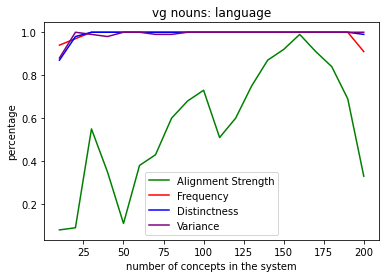

In [79]:
plot_percentage("vg nouns: language",aggregated_vg_noun_data,noun_aoa_sorted,10,noun_freq_dict,noun_language_distinctness,noun_language_variance,num_simulation=100,concept_all=True)

6.507066249847412
[10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200]


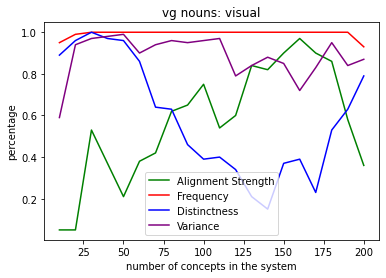

In [80]:
plot_percentage("vg nouns: visual",aggregated_vg_noun_data,noun_aoa_sorted,10,noun_freq_dict,noun_visual_distinctness,noun_visual_variance,num_simulation=100,concept_all=True)

6.4262800216674805
[10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200]


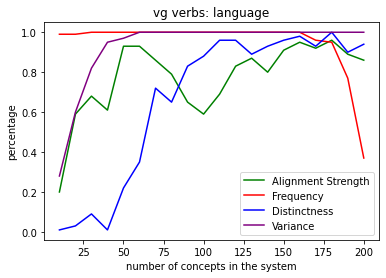

In [85]:
plot_percentage("vg verbs: language",aggregated_vg_verb_data,verb_aoa_sorted,10,verb_freq_dict,verb_language_distinctness,verb_language_variance,num_simulation=100,concept_all=True)

6.533416986465454
[10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200]


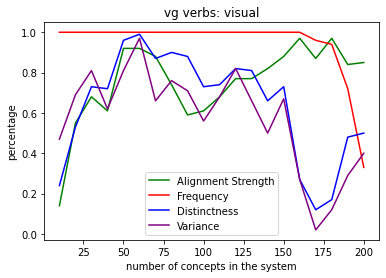

In [82]:
plot_percentage("vg verbs: visual",aggregated_vg_verb_data,verb_aoa_sorted,10,verb_freq_dict,verb_visual_distinctness,verb_visual_variance,num_simulation=100,concept_all=True)

7.553218841552734
[10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210]


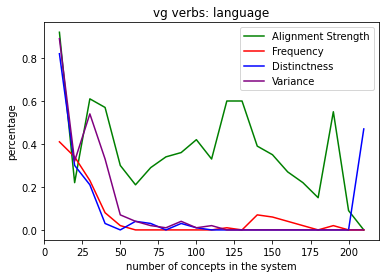

In [71]:
plot_percentage("vg verbs: language",aggregated_vg_verb_data,heaviness_sorted,10,verb_freq_dict,verb_language_distinctness,verb_language_variance,num_simulation=100,concept_all=True)

7.763331174850464
[10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210]


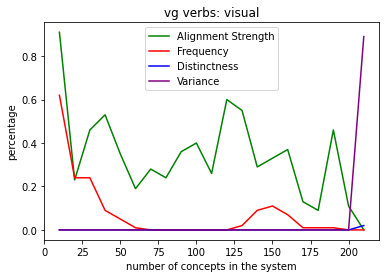

In [72]:
plot_percentage("vg verbs: visual",aggregated_vg_verb_data,heaviness_sorted,10,verb_freq_dict,verb_visual_distinctness,verb_visual_variance,num_simulation=100,concept_all=True)